In [18]:
"""
installing dependencies
"""
!apt-get -qq -y install libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay


/bin/sh: apt-get: command not found
ln: /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so: No such file or directory
/bin/sh: apt-get: command not found


In [5]:
"""
Imports
"""

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
import random
from gym import wrappers

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()  # Install XQuartz and open it
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

import matplotlib.animation
import numpy as np
from IPython.display import HTML

In [6]:
import torch
import torchvision

import torch.utils.tensorboard as tb

from PIL import Image

from torch.utils import data 

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from datetime import datetime
import glob, os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Homework 6 - Imitation and Reinforcement Learning

### Getting to know OpenAI Gym. (TODO)


We will be using the OpenAI Gym as our environment -- **we strongly recommend looking over the ["Getting Started" documentation](https://gym.openai.com/docs/) .**


> A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.


![](https://user-images.githubusercontent.com/8510097/31701297-3ebf291c-b384-11e7-8289-24f1d392fb48.PNG)


>The goal position is 0.5, the location of the flag on top of the hill.

>Reward: -1 for each time step, until the goal position of 0.5 is reached.

>Initialization: Random position from -0.6 to -0.4 with no velocity.

>Episode ends when you reach 0.5 position, or if 200 timesteps are reached. (So failure to reach the flag will result in a reward of -200).


The action space is:  Discrete(3)
The state space is:  Box(2,)
Start episodes......
Episode  1 : Reward  -200.0
Episode  2 : Reward  -200.0
Episode  3 : Reward  -200.0
Episode  4 : Reward  -200.0
Episode  5 : Reward  -200.0
Episode  6 : Reward  -200.0
Episode  7 : Reward  -200.0
Episode  8 : Reward  -200.0
Episode  9 : Reward  -200.0
Episode  10 : Reward  -200.0


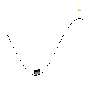

In [5]:
class ResizeObservation(gym.Wrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        if isinstance(shape, int):
            shape = (shape, shape)
        assert all(x > 0 for x in shape), shape
        self.env = env
        self.shape = tuple(shape)

    def render(self):

        from PIL import Image
        obs = self.env.render(mode = 'rgb_array')
        im = Image.fromarray(np.uint8(obs))
        im = im.resize(self.shape)
        return np.asarray(im)



def dummy_policy(env, num_episodes):
    '''
    TODO: Fill in this function 

    Functionality: This should be executing a random policy sampled from the action space of the environment for num_episodes long
                    and should be returning the mean reward over those episodes and the frames of the rendering recorded on the last episode 
  
    Input: env, the MountainCar environment object 
            num_episodes, int, the total number of episodes you want to run this for 

    Returns: mean_reward, float, which is the mean_reward over num_episodes 
           frames, a list, which should contain elements of image dimensions (i.e RGB, with size that you specify), should have a length of the last episode that you record.

    '''
    # Find out the dimensionality of the state and action space
    # 3 actions: Going Left, right and stop. 2 states: (position, velocity)
    print('The action space is: ', env.action_space)
    print('The state space is: ', env.observation_space)

    # initialize the parameters
    mean_reward = 0
    frames = []
    
    print('Start episodes......')
    for episode in range(1, num_episodes + 1):
        observation = env.reset()
        cur_reward = 0
        done = reached = False
        while bool(not done and cur_reward >= -200 and not reached):
            # frames.append(env.render()) if episode is num_episodes else env.render()
            if episode is num_episodes: frames.append(env.render())
            observation, reward, done, _ = env.step(env.action_space.sample())
            reached = bool(observation[0] >= 0.5)
            cur_reward += reward
        print('Episode ', episode, ': Reward ', cur_reward)
        mean_reward += (1 / num_episodes) * cur_reward
        
    env.close()
        
    return mean_reward, frames

resize_observation_shape = 100
env = gym.make('MountainCar-v0')
env = ResizeObservation(env, resize_observation_shape)

rew, frames = dummy_policy(env, 10) # mean reward is -200.

#### Video plotting code ######################
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
ani.save('Dummy Policy.mp4')
HTML(ani.to_jshtml())

## Expert Reinforcement Learning Code - Q-Learning


You are given the code for training a traditional Q-learning based agent. Please go through this code.

### Supporting functions

In [209]:
def discretize(state, discretization, env):

    env_minimum = env.observation_space.low
    state_adj = (state - env_minimum)*discretization
    discretized_state = np.round(state_adj, 0).astype(int)

    return discretized_state


def choose_action(epsilon, Q, state, env):
    """    
    Choose an action according to an epsilon greedy strategy.
    Args:
        epsilon (float): the probability of choosing a random action
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state (Box(2,)): the observation state, here it is [position, velocity]
        env: the RL environment 
        
    Returns:
        action (int): the chosen action
    """
    action = 0
    if np.random.random() < 1 - epsilon:
        action = np.argmax(Q[state[0], state[1]]) 
    else:
        action = np.random.randint(0, env.action_space.n)
  
    return action


def update_epsilon(epsilon, decay_rate):
    """
    Decay epsilon by the specified rate.
    
    Args:
        epsilon (float): the probability of choosing a random action
        decay_rate (float): the decay rate (between 0 and 1) to scale epsilon by
        
    Returns:
        updated epsilon
    """
  
    epsilon *= decay_rate

    return epsilon


def update_Q(Q, state_disc, next_state_disc, action, discount, learning_rate, reward, terminal):
    """
    
    Update Q values following the Q-learning update rule. 
    
    Be sure to handle the terminal state case.
    
    Args:
        Q (np.array): The Q value matrix, here it is 3D for the two observation states and action states
        state_disc (np.array): the discretized version of the current observation state [position, velocity]
        next_state_disc (np.array): the discretized version of the next observation state [position, velocity]
        action (int): the chosen action
        discount (float): the discount factor, may be referred to as gamma
        learning_rate (float): the learning rate, may be referred to as alpha
        reward (float): the current (immediate) reward
        terminal (bool): flag for whether the state is terminal
        
    Returns:
        Q, with the [state_disc[0], state_disc[1], action] entry updated.
    """    
    if terminal:        
        Q[state_disc[0], state_disc[1], action] = reward

    # Adjust Q value for current state
    else:
        delta = learning_rate*(reward + discount*np.max(Q[next_state_disc[0], next_state_disc[1]]) - Q[state_disc[0], state_disc[1],action])
        Q[state_disc[0], state_disc[1],action] += delta
  
    return Q

#### Wrapper for Rendering the Environment

In [24]:
class ResizeObservation(gym.Wrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        if isinstance(shape, int):
            shape = (shape, shape)
        assert all(x > 0 for x in shape), shape
        self.env = env
        self.shape = tuple(shape)

    def render(self):

        from PIL import Image
        obs = self.env.render(mode = 'rgb_array')
        im = Image.fromarray(np.uint8(obs))
        im = im.resize(self.shape)
        return np.asarray(im)

### Main Q-learning Loop

In [96]:
def Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes=5000):
    """
    
    The main Q-learning function, utilizing the functions implemented above.
          
    """
    reward_list = []
    position_list = []
    success_list = []
    success = 0 # count of number of successes reached 
    frames = []
  
    for i in range(max_episodes):
        # Initialize parameters
        done = False # indicates whether the episode is done
        terminal = False # indicates whether the episode is done AND the car has reached the flag (>=0.5 position)
        tot_reward = 0 # sum of total reward over a single
        state = env.reset() # initial environment state
        state_disc = discretize(state,discretization,env)

        while done != True:                 
            # Determine next action 
            action = choose_action(epsilon, Q, state_disc, env)                                      
            # Get next_state, reward, and done using env.step(), see http://gym.openai.com/docs/#environments for reference
            if i==1 or i==(max_episodes-1):
              frames.append(env.render())
            next_state, reward, done, _ = env.step(action) 
            # Discretize next state 
            next_state_disc = discretize(next_state,discretization,env)
            # Update terminal
            terminal = done and next_state[0]>=0.5
            # Update Q
            Q = update_Q(Q,state_disc,next_state_disc,action,discount,learning_rate, reward, terminal)  
            # Update tot_reward, state_disc, and success (if applicable)
            tot_reward += reward
            state_disc = next_state_disc

            if terminal: success +=1 
            
        epsilon = update_epsilon(epsilon, decay_rate) #Update level of epsilon using update_epsilon()

        # Track rewards
        reward_list.append(tot_reward)
        position_list.append(next_state[0])
        success_list.append(success/(i+1))

        if (i+1) % 100 == 0:
            print('Episode: ', i+1, 'Average Reward over 100 Episodes: ',np.mean(reward_list))
            reward_list = []
                
    env.close()
    
    return Q, position_list, success_list, frames

### Define Params and Launch Q-learning

In [97]:
# Initialize Mountain Car Environment
env = gym.make('MountainCar-v0')

env = ResizeObservation(env,100) #Resize observations

env.seed(42)
np.random.seed(42)
env.reset()

# Parameters    
learning_rate = 0.2 
discount = 0.9
epsilon = 0.8 
decay_rate = 0.95
max_episodes = 5000
discretization = np.array([10,100])


#InitQ
num_states = (env.observation_space.high - env.observation_space.low)*discretization
#Size of discretized state space 
num_states = np.round(num_states, 0).astype(int) + 1
# Initialize Q table
Q = np.random.uniform(low = -1, 
                      high = 1, 
                      size = (num_states[0], num_states[1], env.action_space.n))

# Run Q Learning by calling your Qlearning() function
Q, position, successes, frames = Qlearning(Q, discretization, env, learning_rate, discount, epsilon, decay_rate, max_episodes)

np.save('./expert_Q.npy',Q) #Save the expert

Episode:  100 Average Reward over 100 Episodes:  -200.0
Episode:  200 Average Reward over 100 Episodes:  -200.0
Episode:  300 Average Reward over 100 Episodes:  -199.31
Episode:  400 Average Reward over 100 Episodes:  -199.5
Episode:  500 Average Reward over 100 Episodes:  -187.22
Episode:  600 Average Reward over 100 Episodes:  -197.59
Episode:  700 Average Reward over 100 Episodes:  -193.0
Episode:  800 Average Reward over 100 Episodes:  -198.56
Episode:  900 Average Reward over 100 Episodes:  -178.68
Episode:  1000 Average Reward over 100 Episodes:  -179.05
Episode:  1100 Average Reward over 100 Episodes:  -177.91
Episode:  1200 Average Reward over 100 Episodes:  -157.72
Episode:  1300 Average Reward over 100 Episodes:  -185.27
Episode:  1400 Average Reward over 100 Episodes:  -176.04
Episode:  1500 Average Reward over 100 Episodes:  -191.86
Episode:  1600 Average Reward over 100 Episodes:  -184.11
Episode:  1700 Average Reward over 100 Episodes:  -170.33
Episode:  1800 Average Rewa

### Visualization

#### Plotting

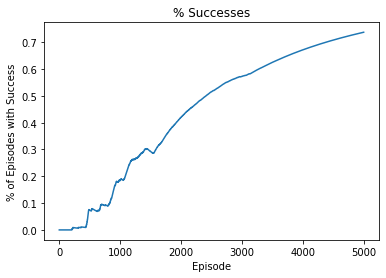

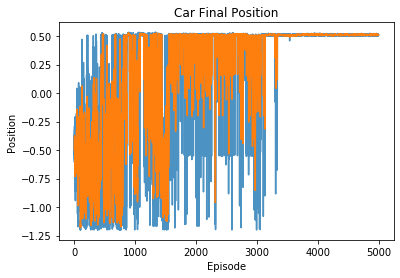

In [11]:
import pandas as pd 

plt.plot(successes)
plt.xlabel('Episode')
plt.ylabel('% of Episodes with Success')
plt.title('% Successes')
plt.show()
plt.close()

p = pd.Series(position)
ma = p.rolling(3).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

#### Agent's Video

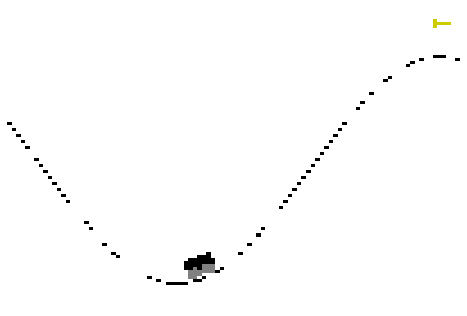

In [13]:
#### Video plotting code #####################
deep_frames = []
for obs in frames:
  im = Image.fromarray(np.uint8(obs))
  im = im.resize((600,400))
  deep_frames.append(np.asarray(im))

plt.figure(figsize=(deep_frames[0].shape[1] / 72.0, deep_frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(deep_frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(deep_frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(deep_frames), interval = 50)
ani.save('Expert Policy.mp4')
HTML(ani.to_jshtml())

### Generate Expert Trajectories (TODO):

Using the Q-learning agent above, please complete this block of code to generate expert trajectories

#### Get actions from expert for a specific observation

In [205]:
def get_expert_action(Q, discretization, env, state):
    '''
      TODO: Implement this function

      NOTE: YOU WILL BE USING THIS FUNCTION FOR THE IMITATION LEARNING SECTION AS WELL 

      Functionality: For a given state, returns the action that the expert would take 

      Input: Q value , numpy array
             the discretization 
             env , the environment
             state, (Box(2,)): the observation space state, here it is [position, velocity]

      Returns: action, has dimensions of the action space and type of action space
    '''
    state_disc = discretize(state, discretization, env)
    action = np.argmax(Q[state_disc[0], state_disc[1]])
    
    return action

#### Generate Expert Trajectory

In [206]:
def generate_expert_trajectories(Q, discretization, env, num_episodes=150, data_path='./data'):
    """
    TODO: Implement this function

      Functionality: Execute Expert Trajectories and Save them under the folder of data_path/

      Input: Q value , numpy array
             the discretization 
             env , the environment
             num_episodes, int, which is used to denote number of expert trajectories to store 

      Returns: total_samples, int, which denotes the total number of samples that were stored
    """
    total_samples = 0
    episode_dict = {}
    for episode in range(1, num_episodes + 1):
        states = env.reset()
        done = reached = False
        cur_reward = 0
        episode_observations = []
        episode_actions = []
        while bool(not done and not reached and cur_reward >= -200):
            episode_observations.append(discretize(states, discretization, env))
            action = get_expert_action(Q, discretization, env, states)
            episode_actions.append(action)
            states, reward, done, _ = env.step(action)
            cur_reward += reward
            reached = bool(states[0] >= 0.5)
            
        # track the total samples
        total_samples += len(episode_actions)
        
        episode_dict['observations'] = episode_observations
        episode_dict['actions'] = episode_actions
        import os
        if not os.path.exists(data_path):
            os.makedirs(data_path)
        np.savez_compressed(data_path + '/episode_number' + '_' + str(episode) + '.npz',**episode_dict) #where i can be the episode number that you save
        
    return total_samples 

#### Launch code for generating trajectories

In [ ]:
num_episodes = 100
data_path = './data'

Q = np.load('./expert_Q.npy') # load the expert
total_samples = generate_expert_trajectories(Q,discretization,env,num_episodes, data_path) ## Generate trajectories. Use Q, discretization and env by running the previous section

print('---------Total Samples Recorded were --------', total_samples)

## Imitation Learning

Using the trajectories that you collected from the expert above, you will work on imitation learning agents in the code sections below

### Working with Data (TODO)




#### Loading Initial Expert Data

In [574]:
def load_initial_data(args):
    """
    TODO: Fill this function

    Functionality: Reads data from directory and converts them into numpy arrays of observations and actions

    Input arguments: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
  
    Returns: training_observations: numpy array, of shape (B,dim_of_observation), where B is total number of samples that you select
            training_actions: numpy array, of shape (B,dim_of_action), where B is total number of samples that you select
    """
    # initialize the observations and actions 
    training_observations = np.array([]).reshape(0, 2)
    training_actions = np.array([]).reshape(0,)
    episode_counter = 0
    
    for file in os.listdir(args.datapath):
        if file.endswith(".npz"):
            data = np.load(os.path.join(args.datapath, file))
            # concatenate the observations and actions data for the targeted episodes
            training_observations = np.concatenate((training_observations, data['observations']), axis = 0)
            training_actions = np.concatenate( (training_actions, data['actions']), axis = 0)
            episode_counter += 1
        if episode_counter == args.initial_episodes_to_use: break
            
    return training_observations, training_actions

#### Convert numpy arrays to a Dataloader

In [297]:

def load_dataset(args, observations, actions, batch_size=64, data_transforms=None, num_workers=0):
    """
    TODO: Fill this function fully 

    Functionality: Converts numpy arrays to dataloaders. 
  
    Inputs: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
            observations, numpy array, of shape (B,dim_of_observation), where B is number of samples 
            actions, numpy array, of shape (B,dim_of_action), where B is number of samples 
            batch_size, int, which you can play around with, but is set to 64 by default. 
            data_transforms, whatever transformations you want to make to your data.

    Returns: dataloader  
    """
    from torch.utils.data import TensorDataset
    dataset = TensorDataset(torch.Tensor(observations), torch.Tensor(actions))
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
    return dataloader

#### Process Individual Observations

In [212]:
def process_individual_observation(args,observation):
    """
    TODO: Fill this function fully 

    Functionality: Converts individual observations according to the pre-processing that you want  
  
    Inputs: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
            observations, shape (dim_of_observation)

    Returns: data, processed observation that can be fed into the model
    """
    data = torch.Tensor(discretize(observation, args.discretization, args.env))
    return data

### Defining Networks (TODO)

#### Define your network for working from States

In [573]:
class StatesNetwork(nn.Module):
    """
    TODO: Implement this class
    """
    def __init__(self, env):
        """
        Your code here
        """
        super(StatesNetwork, self).__init__()
        
        self.fc1 = torch.nn.Linear(env.observation_space.shape[0], 300)
        self.act1 = torch.nn.ReLU()
        self.drop1 = torch.nn.Dropout(p = 0.5)
        
        self.fc2 = torch.nn.Linear(300, env.action_space.n)
        self.softmax = torch.nn.Softmax() # get probability distribution 
        
        self.classifier = torch.nn.Sequential( self.fc1, self.act1, self.drop1,
                                            self.fc2, self.softmax )
        
        
        
    
    def forward(self, x):    
        """
        Your code here
        @x: torch.Tensor((B,dim_of_observation))
        @return: torch.Tensor((B,dim_of_actions))
        """
        forward_pass = self.classifier(x)
        
        return forward_pass

### Training the model (TODO)

In [570]:
from torch import save
from torch import load
from os import path

def save_model(model, filename):
    if isinstance(model, StatesNetwork):
        return save(model.state_dict(), path.join(path.abspath(''), filename))
    
    raise ValueError("model type '%s' not supported!"%str(type(model)))


def load_model(filename, args):
    r = StatesNetwork(args.env)
    r.load_state_dict(load(path.join(path.abspath(''), filename), map_location='cpu'))
    return r

In [643]:
def train_model(args):
    """
    TODO: Fill in the entire train function

    Functionality: Trains the model. How you train this is upto you. 

    Input: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 

    Returns: The trained model 
    """
    # initialize some record parameters
    total_frames = []
    
    # initialize the model
    model = args.model.to(device)
    model.train()
    
    # initialize the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr = args.learning_rate, 
                                momentum = args.momentum, weight_decay = args.weight_decay)
    
        
    for epoch in range(1, args.num_epochs + 1):
        model.train()
        # data gets shuffled everytime
        cur_batch_samples = 0
        for batch_idx, (ob, ac) in enumerate(args.dataloader):
            optimizer.zero_grad()
            ob, ac = ob.to(device), ac.to(device)
            output = model(ob)
            # comput loss
            output = -1 * torch.log(output) # Negative Log-likehood
            ac = ac.long() # convert data type to long
            loss = torch.mean( torch.gather(output, 1, ac.view(ac.size(0), 1)) ) # TODO:
            loss.backward()
            optimizer.step()
            
            # update current batch sample size
            cur_batch_samples += len(ob)
            if batch_idx % args.log_interval == 0:
                args.train_losses.append(loss.item())
                args.train_counter.append( cur_batch_samples 
                                          + (epoch - 1) * len(args.dataloader.dataset)
                                          + args.prev_train_endNum)
        
                print('Train Epoch: {} [{}/{} ({:.0f}%)]      Loss: {:.6f}'.format(
                    epoch, cur_batch_samples, len(args.dataloader.dataset),
                    100. * (batch_idx + 1) / len(args.dataloader), loss.item()))
                        
        args.model = model    
        # record the mean reward and success rate over 5 episodes at the end of each epoch
        average_final_positions, average_success_rate, average_episode_rewards, frames = get_average_performance(args, run_for = args.num_test_episode)
        args.agent_reward.append(average_episode_rewards)
        args.agent_success.append(average_success_rate)
        args.final_positions.append(average_final_positions)
        args.total_frames.append(frames)
        
        print('Train Epoch: {} [ Mean Reward: {:.2f}, Success Rate: {:.2f}, Final Position: {:.2f} ]'.format(
            epoch, average_episode_rewards, average_success_rate, average_final_positions))
        
    args.prev_train_endNum = args.train_counter[-1]
    
    return model

### DAgger (TODO)

#### Get the expert trajectory for imitating agent's observations

In [541]:
def execute_dagger(args):
    """
    TODO: Implement this function

    Functionality: Collect expert labels for the observations seen by the imitation learning agent 
  
    Input: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
         
    Returns: imitation_observations, a numpy array that has dimensions of (episode_length,dim_of_observation)
        expert_actions, a numpy array that has dimensions of (episode_length,dim_of_action)
    """
    states = args.env.reset()
    done = reached = False
    cur_reward = 0
    # initialize the observations and actions 
    imitation_observations = np.array([]).reshape(0, 2)
    expert_actions = np.array([]).reshape(0,)
    
    while bool(not done and not reached and cur_reward >= -200):
        state_disc = discretize(states, args.discretization, args.env)
        imitation_observations = np.concatenate((imitation_observations, 
                                                 state_disc.reshape(1,2)), axis = 0)
        action = get_expert_action(args.Q, args.discretization, args.env, states)
        expert_actions = np.concatenate((expert_actions, 
                                         np.array(action).reshape(1,)), axis = 0)
        
        state_disc = torch.Tensor(state_disc) # convert to tensor
        states, reward, done, _ = args.env.step(torch.argmax(args.model(state_disc)).item())
        cur_reward += reward
        reached = bool(states[0] >= 0.5)
    return imitation_observations, expert_actions

#### Aggregate new rollout to the full dataset

In [278]:
def aggregate_dataset(training_observations, training_actions, imitation_states, expert_actions):
    """
    TODO: Implement this function

    Functionality: Adds new expert labeled rollout to the overall dataset

    Input: training_observations, a numpy array that has dimensions of (dataset_size,dim_of_observation)
        training_actions, a numpy array that has dimensions of (dataset_size,dim_of_action)
        imitation_observations, a numpy array that has dimensions of (episode_length,dim_of_observation)
        expert_actions, a numpy array that has dimensions of (episode_length,dim_of_action)

    Returns: training_observations, a numpy array that has dimensions of (updated_dataset_size,dim_of_observation)
        training_actions, a numpy array that has dimensions of (updated_dataset_size,dim_of_action)
    """
    training_observations = np.concatenate((training_observations, imitation_states), axis = 0)
    training_actions = np.concatenate((training_actions, expert_actions), axis = 0)

    return training_observations, training_actions 

### Utility 



#### Code for prediction of the network and calculating the accuracy 

In [279]:
import numpy as np
from torchvision.transforms import functional as TF

def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

def predict(model, inputs, device='cpu'):
    inputs = inputs.to(device)
    logits = model(inputs)
    return F.softmax(logits, -1)

#### Wrapper for Rendering the environment 

Same code that was used in the Q-learning agent

In [280]:
class ResizeObservation(gym.Wrapper):
    def __init__(self, env, shape):
        super(ResizeObservation, self).__init__(env)
        if isinstance(shape, int):
            shape = (shape, shape)
        assert all(x > 0 for x in shape), shape
        self.env = env
        self.shape = tuple(shape)

    def render(self):

        from PIL import Image
        obs = self.env.render(mode = 'rgb_array')
        im = Image.fromarray(np.uint8(obs))
        im = im.resize(self.shape)
        return np.asarray(im)

### Test model performance

In [461]:
def test_model(args, record_frames=False):

    '''
  Functionality: Should take your model and run it for a complete episode (model should either not finish the game in 200 steps or finish the game). Record stats

  Input: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 
         record_frames, Boolean. Denotes if you want to record frames to display them as video.

  Returns: final_position, The final position of the car when the episode ended
           success, Boolean, denotes if the episode was a success or not
           frames, a list of frames that have been rendered throughout the episode. Should have a length of the total episode length
           episode_reward, float, denotes the total rewards obtained while executing this episode
  '''

    frames = []
    env = args.env 
    model = args.model
    state = env.reset()

    model.eval()

    episode_reward = 0

    success = False
    done = False 

    while not done:

        observation = state

        data = process_individual_observation(args, observation)
        logit = model(data)
        action = torch.argmax(logit).item()

        if record_frames: #You can change the rate of recording frames as you like
            frames.append(env.render())

        next_state, reward, done, _ = env.step(action) 
        episode_reward += reward

        if done:    
            if next_state[0] >= 0.5:
                success = True
            final_position = next_state[0]
            return final_position, success, frames, episode_reward
        else:
            state = next_state

### Average Performance Metrics
Use this function to see how well your agent is doing.

In [631]:
def get_average_performance(args, run_for=1000):
    final_positions = 0
    successes = 0
    rewards = 0
    total_frames = []


    for ep in range(run_for):
        pos, success, frames, episode_rewards = test_model(args, record_frames = args.record_frames)   #test imitation policy
        total_frames.append(frames)
        final_positions += pos 
        rewards += episode_rewards
        if success:
          successes += 1
        print('Running Episode: ',ep,' Success: ', success)
        average_final_positions = final_positions/(ep+1)
        average_success_rate = 100*(successes/(ep+1))
        average_episode_rewards = rewards/(ep+1)

    return average_final_positions, average_success_rate, average_episode_rewards, total_frames

### Main Imitation Learning Method (TODO)



In [639]:
def imitate(args):
    """
    TODO: Implement this function

    Input: args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access 

    Functionality: For a given set of args, performs imitation learning as desired. 

    Returns: final_positions, A list of final positions achieved by the model during every time it is tested. Should have a list length of args.max_dagger_iterations
            success_history, A list of success percentage achieved by the model during every time it is tested. Should have a list length of args.max_dagger_iterations
            reward_history, A list of episode rewards achieved by the model during every time it is tested. Should have a list length of args.max_dagger_iterations
            frames, A list of video frames of the model executing its policy every time it is tested, can choose to not record. Should have a length of the number of times you chose to record frames
            args, an object with set of parameters and objects that you can treat as an attribute dictionary. Access elements with args.element_you_want_to_access
    """
    # load data
    observations, actions = load_initial_data(args)
    
    args.prev_train_endNum = 0
    # do dagger on top of pi_1 model if dagger is set to True
    if args.do_dagger == True: 
        args.cur_dagger_iter = 0
        args.num_epochs = 2
        args.dataloader = load_dataset(args, observations, actions)
        args.model = train_model(args)
        #args.model = load_model(filename = 'pi_temp.th', args = args)
    
    for dagger_idx in range(1, 1 + args.max_dagger_iterations):
        args.cur_dagger_iter = dagger_idx
        # do dagger if flag is set
        if args.do_dagger == True:
            # Add new Episode
            new_observations, new_actions = execute_dagger(args)
            observations, actions = aggregate_dataset(observations, actions, 
                                                      new_observations, new_actions)
        
        args.dataloader = load_dataset(args, observations, actions)
        args.model = train_model(args)
        print('***************************************************************************')
        print('Dagger Iteration No.{} Done'.format(dagger_idx))
            
    save_model(args.model, args.model_filename)
    
    return args.final_positions, args.agent_success, args.total_frames, args.agent_reward, args

### Launch Imitation Learning (TODO)
Define Args and Launch 'imitate'



In [671]:
'''
TODO: Expand the attributes of Args as you please. 

But please maintain the ones given below, i.e: You should be using the ones given below. Fill them out.

Some of these are already filled out for you. 
'''


##TODO: Fill in the given attributes (you should use these in your code), and add to them as you please.
def get_args():
    class Args(object):
        def __init__(self):
            self.datapath = './data'
            self.model_filename = 'pi_0.th' # pi_0.th for 20 expert episodes, and pi_1.th for 2 expert episodes
            self.env = ResizeObservation(gym.make('MountainCar-v0'), 100)
            self.env.seed(42) # Seed 42 for pi_2. 12 for pi_1 plotting
            self.do_dagger = False
            self.max_dagger_iterations = 1
            if not self.do_dagger: assert self.max_dagger_iterations == 1
            self.record_frames = False
            self.initial_episodes_to_use = 1
            self.total_episodes = 20
            torch.manual_seed(195) # Seed 195 for pi_2 . 43 for pi_1 plotting
            self.model = StatesNetwork(self.env)
            self.num_epochs = 20
            self.curr_epoch = None
            self.Q = np.load('./expert_Q.npy', allow_pickle = True)
            self.discretization = np.array([10, 100])
            self.log_interval = 1
            # NN model parameters
            self.learning_rate = 0.005
            self.momentum = 0.95
            self.weight_decay = 0
            self.optimizer = None
            self.dataloader = None
            # Logging parameter
            self.train_losses = []
            self.train_counter = []
            self.agent_success = []
            self.agent_reward = []
            self.final_positions = []
            self.total_frames = []
            self.num_test_episode = 20
    args = Args();
    args.initial_episodes_to_use = 2
    args.num_epochs = 20
    args.num_test_episode = 5
    args.model_filename = 'pi_2.th'
    args.do_dagger = True
    args.max_dagger_iterations = 18
    if not args.do_dagger: 
        args.max_dagger_iterations = 1
    return args

args = get_args()
positions, successes, frames, reward_history, args = imitate(args)

Train Epoch: 1 [64/304 (20%)]      Loss: 3.895502
Train Epoch: 1 [128/304 (40%)]      Loss: 3.243560
Train Epoch: 1 [192/304 (60%)]      Loss: 5.415604
Train Epoch: 1 [256/304 (80%)]      Loss: 4.524813
Train Epoch: 1 [304/304 (100%)]      Loss: 4.935901
Running Episode:  0  Success:  False
Running Episode:  1  Success:  False
Running Episode:  2  Success:  False
Running Episode:  3  Success:  False
Running Episode:  4  Success:  False
Train Epoch: 1 [ Mean Reward: -200.00, Success Rate: 0.00, Final Position: 0.00 ]
Train Epoch: 2 [64/304 (20%)]      Loss: 4.734188
Train Epoch: 2 [128/304 (40%)]      Loss: 6.589817
Train Epoch: 2 [192/304 (60%)]      Loss: 4.518395
Train Epoch: 2 [256/304 (80%)]      Loss: 3.968708
Train Epoch: 2 [304/304 (100%)]      Loss: 2.617283
Running Episode:  0  Success:  False
Running Episode:  1  Success:  True
Running Episode:  2  Success:  False
Running Episode:  3  Success:  False
Running Episode:  4  Success:  False
Train Epoch: 2 [ Mean Reward: -199.80, 

Running Episode:  0  Success:  False
Running Episode:  1  Success:  False
Running Episode:  2  Success:  False
Running Episode:  3  Success:  False
Running Episode:  4  Success:  False
Train Epoch: 2 [ Mean Reward: -200.00, Success Rate: 0.00, Final Position: -0.71 ]
***************************************************************************
Dagger Iteration No.4 Done
Train Epoch: 1 [64/1304 (5%)]      Loss: 1.530647
Train Epoch: 1 [128/1304 (10%)]      Loss: 1.815983
Train Epoch: 1 [192/1304 (14%)]      Loss: 1.390029
Train Epoch: 1 [256/1304 (19%)]      Loss: 1.419587
Train Epoch: 1 [320/1304 (24%)]      Loss: 1.222518
Train Epoch: 1 [384/1304 (29%)]      Loss: 1.419103
Train Epoch: 1 [448/1304 (33%)]      Loss: 1.165375
Train Epoch: 1 [512/1304 (38%)]      Loss: 1.267459
Train Epoch: 1 [576/1304 (43%)]      Loss: 1.301828
Train Epoch: 1 [640/1304 (48%)]      Loss: 1.470128
Train Epoch: 1 [704/1304 (52%)]      Loss: 1.298511
Train Epoch: 1 [768/1304 (57%)]      Loss: 1.249673
Train E

Train Epoch: 2 [960/1639 (58%)]      Loss: 1.111637
Train Epoch: 2 [1024/1639 (62%)]      Loss: 0.890044
Train Epoch: 2 [1088/1639 (65%)]      Loss: 0.889424
Train Epoch: 2 [1152/1639 (69%)]      Loss: 0.776363
Train Epoch: 2 [1216/1639 (73%)]      Loss: 1.215558
Train Epoch: 2 [1280/1639 (77%)]      Loss: 0.829378
Train Epoch: 2 [1344/1639 (81%)]      Loss: 0.841651
Train Epoch: 2 [1408/1639 (85%)]      Loss: 0.966079
Train Epoch: 2 [1472/1639 (88%)]      Loss: 0.700374
Train Epoch: 2 [1536/1639 (92%)]      Loss: 0.814464
Train Epoch: 2 [1600/1639 (96%)]      Loss: 0.851999
Train Epoch: 2 [1639/1639 (100%)]      Loss: 0.942594
Running Episode:  0  Success:  True
Running Episode:  1  Success:  True
Running Episode:  2  Success:  True
Running Episode:  3  Success:  True
Running Episode:  4  Success:  False
Train Epoch: 2 [ Mean Reward: -154.00, Success Rate: 80.00, Final Position: 0.27 ]
***************************************************************************
Dagger Iteration No.7 Do

Running Episode:  2  Success:  True
Running Episode:  3  Success:  True
Running Episode:  4  Success:  True
Train Epoch: 1 [ Mean Reward: -136.40, Success Rate: 100.00, Final Position: 0.53 ]
Train Epoch: 2 [64/2062 (3%)]      Loss: 0.719035
Train Epoch: 2 [128/2062 (6%)]      Loss: 0.740935
Train Epoch: 2 [192/2062 (9%)]      Loss: 0.684435
Train Epoch: 2 [256/2062 (12%)]      Loss: 0.971571
Train Epoch: 2 [320/2062 (15%)]      Loss: 0.730258
Train Epoch: 2 [384/2062 (18%)]      Loss: 0.868409
Train Epoch: 2 [448/2062 (21%)]      Loss: 1.042244
Train Epoch: 2 [512/2062 (24%)]      Loss: 0.737496
Train Epoch: 2 [576/2062 (27%)]      Loss: 0.800907
Train Epoch: 2 [640/2062 (30%)]      Loss: 1.007095
Train Epoch: 2 [704/2062 (33%)]      Loss: 0.888971
Train Epoch: 2 [768/2062 (36%)]      Loss: 0.912818
Train Epoch: 2 [832/2062 (39%)]      Loss: 0.930238
Train Epoch: 2 [896/2062 (42%)]      Loss: 0.753735
Train Epoch: 2 [960/2062 (45%)]      Loss: 0.776273
Train Epoch: 2 [1024/2062 (48%)]

Running Episode:  1  Success:  False
Running Episode:  2  Success:  True
Running Episode:  3  Success:  False
Running Episode:  4  Success:  True
Train Epoch: 1 [ Mean Reward: -179.80, Success Rate: 40.00, Final Position: -0.37 ]
Train Epoch: 2 [64/2404 (3%)]      Loss: 0.798450
Train Epoch: 2 [128/2404 (5%)]      Loss: 0.787862
Train Epoch: 2 [192/2404 (8%)]      Loss: 0.946413
Train Epoch: 2 [256/2404 (11%)]      Loss: 0.910664
Train Epoch: 2 [320/2404 (13%)]      Loss: 0.871210
Train Epoch: 2 [384/2404 (16%)]      Loss: 0.742179
Train Epoch: 2 [448/2404 (18%)]      Loss: 0.773210
Train Epoch: 2 [512/2404 (21%)]      Loss: 0.673073
Train Epoch: 2 [576/2404 (24%)]      Loss: 1.039409
Train Epoch: 2 [640/2404 (26%)]      Loss: 0.878065
Train Epoch: 2 [704/2404 (29%)]      Loss: 0.755655
Train Epoch: 2 [768/2404 (32%)]      Loss: 1.054878
Train Epoch: 2 [832/2404 (34%)]      Loss: 1.061540
Train Epoch: 2 [896/2404 (37%)]      Loss: 1.076031
Train Epoch: 2 [960/2404 (39%)]      Loss: 0.9

Running Episode:  3  Success:  True
Running Episode:  4  Success:  True
Train Epoch: 1 [ Mean Reward: -143.40, Success Rate: 100.00, Final Position: 0.51 ]
Train Epoch: 2 [64/2692 (2%)]      Loss: 0.848223
Train Epoch: 2 [128/2692 (5%)]      Loss: 0.910698
Train Epoch: 2 [192/2692 (7%)]      Loss: 0.967201
Train Epoch: 2 [256/2692 (9%)]      Loss: 1.080338
Train Epoch: 2 [320/2692 (12%)]      Loss: 0.790614
Train Epoch: 2 [384/2692 (14%)]      Loss: 0.874972
Train Epoch: 2 [448/2692 (16%)]      Loss: 0.942621
Train Epoch: 2 [512/2692 (19%)]      Loss: 0.800491
Train Epoch: 2 [576/2692 (21%)]      Loss: 0.915261
Train Epoch: 2 [640/2692 (23%)]      Loss: 0.925363
Train Epoch: 2 [704/2692 (26%)]      Loss: 0.841316
Train Epoch: 2 [768/2692 (28%)]      Loss: 0.910027
Train Epoch: 2 [832/2692 (30%)]      Loss: 0.890009
Train Epoch: 2 [896/2692 (33%)]      Loss: 0.864722
Train Epoch: 2 [960/2692 (35%)]      Loss: 0.781041
Train Epoch: 2 [1024/2692 (37%)]      Loss: 0.885670
Train Epoch: 2 [

Running Episode:  3  Success:  True
Running Episode:  4  Success:  True
Train Epoch: 1 [ Mean Reward: -148.00, Success Rate: 100.00, Final Position: 0.51 ]
Train Epoch: 2 [64/3030 (2%)]      Loss: 0.932386
Train Epoch: 2 [128/3030 (4%)]      Loss: 0.987170
Train Epoch: 2 [192/3030 (6%)]      Loss: 0.742569
Train Epoch: 2 [256/3030 (8%)]      Loss: 0.893432
Train Epoch: 2 [320/3030 (10%)]      Loss: 0.919166
Train Epoch: 2 [384/3030 (12%)]      Loss: 0.781514
Train Epoch: 2 [448/3030 (15%)]      Loss: 0.732804
Train Epoch: 2 [512/3030 (17%)]      Loss: 0.696747
Train Epoch: 2 [576/3030 (19%)]      Loss: 0.674844
Train Epoch: 2 [640/3030 (21%)]      Loss: 0.820107
Train Epoch: 2 [704/3030 (23%)]      Loss: 0.635603
Train Epoch: 2 [768/3030 (25%)]      Loss: 0.982553
Train Epoch: 2 [832/3030 (27%)]      Loss: 1.094275
Train Epoch: 2 [896/3030 (29%)]      Loss: 0.870985
Train Epoch: 2 [960/3030 (31%)]      Loss: 0.845918
Train Epoch: 2 [1024/3030 (33%)]      Loss: 1.000707
Train Epoch: 2 [

Running Episode:  4  Success:  True
Train Epoch: 2 [ Mean Reward: -153.60, Success Rate: 100.00, Final Position: 0.50 ]
***************************************************************************
Dagger Iteration No.17 Done
Train Epoch: 1 [64/3324 (2%)]      Loss: 0.946865
Train Epoch: 1 [128/3324 (4%)]      Loss: 0.750256
Train Epoch: 1 [192/3324 (6%)]      Loss: 0.751453
Train Epoch: 1 [256/3324 (8%)]      Loss: 0.897614
Train Epoch: 1 [320/3324 (10%)]      Loss: 0.867210
Train Epoch: 1 [384/3324 (12%)]      Loss: 0.875232
Train Epoch: 1 [448/3324 (13%)]      Loss: 0.705476
Train Epoch: 1 [512/3324 (15%)]      Loss: 0.843888
Train Epoch: 1 [576/3324 (17%)]      Loss: 0.861051
Train Epoch: 1 [640/3324 (19%)]      Loss: 0.848278
Train Epoch: 1 [704/3324 (21%)]      Loss: 0.856706
Train Epoch: 1 [768/3324 (23%)]      Loss: 0.876798
Train Epoch: 1 [832/3324 (25%)]      Loss: 0.800411
Train Epoch: 1 [896/3324 (27%)]      Loss: 1.019011
Train Epoch: 1 [960/3324 (29%)]      Loss: 0.780353
T

### Average Performance Evaluation

See how well your agent is doing. 

In [651]:
final_pos, succ_rate, ep_rwds, _ = get_average_performance(args)

print('Average Final Position achieved by the Agent: ',final_pos)
print('Average Success Rate achieved by the Agent: ',succ_rate)
print('Average Episode Reward achieved by the Agent: ',ep_rwds)

Running Episode:  0  Success:  True
Running Episode:  1  Success:  True
Running Episode:  2  Success:  True
Running Episode:  3  Success:  True
Running Episode:  4  Success:  True
Running Episode:  5  Success:  True
Running Episode:  6  Success:  True
Running Episode:  7  Success:  True
Running Episode:  8  Success:  True
Running Episode:  9  Success:  True
Running Episode:  10  Success:  True
Running Episode:  11  Success:  True
Running Episode:  12  Success:  True
Running Episode:  13  Success:  True
Running Episode:  14  Success:  True
Running Episode:  15  Success:  True
Running Episode:  16  Success:  True
Running Episode:  17  Success:  True
Running Episode:  18  Success:  True
Running Episode:  19  Success:  True
Running Episode:  20  Success:  True
Running Episode:  21  Success:  True
Running Episode:  22  Success:  True
Running Episode:  23  Success:  True
Running Episode:  24  Success:  True
Running Episode:  25  Success:  True
Running Episode:  26  Success:  True
Running Epi

Running Episode:  220  Success:  True
Running Episode:  221  Success:  True
Running Episode:  222  Success:  True
Running Episode:  223  Success:  True
Running Episode:  224  Success:  True
Running Episode:  225  Success:  True
Running Episode:  226  Success:  True
Running Episode:  227  Success:  True
Running Episode:  228  Success:  True
Running Episode:  229  Success:  True
Running Episode:  230  Success:  True
Running Episode:  231  Success:  True
Running Episode:  232  Success:  True
Running Episode:  233  Success:  True
Running Episode:  234  Success:  True
Running Episode:  235  Success:  True
Running Episode:  236  Success:  True
Running Episode:  237  Success:  True
Running Episode:  238  Success:  True
Running Episode:  239  Success:  True
Running Episode:  240  Success:  True
Running Episode:  241  Success:  True
Running Episode:  242  Success:  True
Running Episode:  243  Success:  True
Running Episode:  244  Success:  True
Running Episode:  245  Success:  True
Running Epis

Running Episode:  436  Success:  True
Running Episode:  437  Success:  True
Running Episode:  438  Success:  True
Running Episode:  439  Success:  True
Running Episode:  440  Success:  True
Running Episode:  441  Success:  True
Running Episode:  442  Success:  True
Running Episode:  443  Success:  True
Running Episode:  444  Success:  True
Running Episode:  445  Success:  True
Running Episode:  446  Success:  True
Running Episode:  447  Success:  True
Running Episode:  448  Success:  True
Running Episode:  449  Success:  True
Running Episode:  450  Success:  True
Running Episode:  451  Success:  True
Running Episode:  452  Success:  True
Running Episode:  453  Success:  True
Running Episode:  454  Success:  True
Running Episode:  455  Success:  True
Running Episode:  456  Success:  True
Running Episode:  457  Success:  True
Running Episode:  458  Success:  True
Running Episode:  459  Success:  True
Running Episode:  460  Success:  True
Running Episode:  461  Success:  True
Running Epis

Running Episode:  657  Success:  True
Running Episode:  658  Success:  True
Running Episode:  659  Success:  True
Running Episode:  660  Success:  True
Running Episode:  661  Success:  True
Running Episode:  662  Success:  True
Running Episode:  663  Success:  True
Running Episode:  664  Success:  True
Running Episode:  665  Success:  True
Running Episode:  666  Success:  True
Running Episode:  667  Success:  True
Running Episode:  668  Success:  True
Running Episode:  669  Success:  True
Running Episode:  670  Success:  True
Running Episode:  671  Success:  True
Running Episode:  672  Success:  True
Running Episode:  673  Success:  True
Running Episode:  674  Success:  True
Running Episode:  675  Success:  True
Running Episode:  676  Success:  True
Running Episode:  677  Success:  True
Running Episode:  678  Success:  True
Running Episode:  679  Success:  True
Running Episode:  680  Success:  True
Running Episode:  681  Success:  True
Running Episode:  682  Success:  True
Running Epis

Running Episode:  876  Success:  True
Running Episode:  877  Success:  True
Running Episode:  878  Success:  True
Running Episode:  879  Success:  True
Running Episode:  880  Success:  True
Running Episode:  881  Success:  True
Running Episode:  882  Success:  True
Running Episode:  883  Success:  True
Running Episode:  884  Success:  True
Running Episode:  885  Success:  True
Running Episode:  886  Success:  True
Running Episode:  887  Success:  True
Running Episode:  888  Success:  True
Running Episode:  889  Success:  True
Running Episode:  890  Success:  True
Running Episode:  891  Success:  True
Running Episode:  892  Success:  True
Running Episode:  893  Success:  True
Running Episode:  894  Success:  True
Running Episode:  895  Success:  True
Running Episode:  896  Success:  True
Running Episode:  897  Success:  True
Running Episode:  898  Success:  True
Running Episode:  899  Success:  True
Running Episode:  900  Success:  True
Running Episode:  901  Success:  True
Running Epis

### Visualization

#### Plotting code

Use the code below to make plots to see how well your agent did as it trained. 

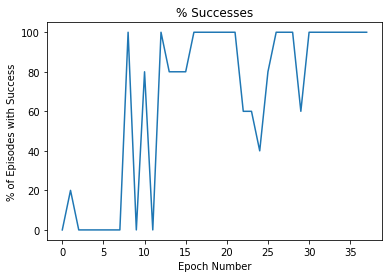

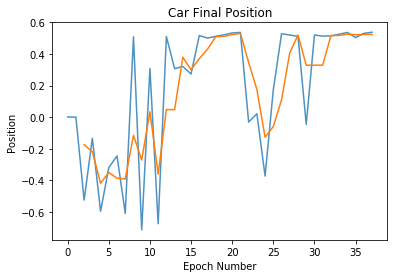

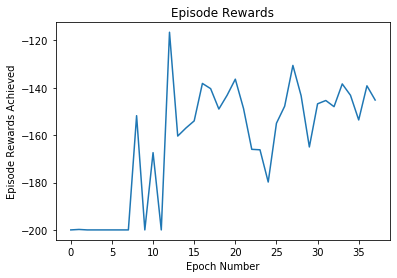

In [672]:
import pandas as pd 

plt.plot(successes)
plt.xlabel('Epoch Number')
plt.ylabel('% of Episodes with Success')
plt.title('% Successes')
plt.savefig('Epoch Number with Success ' + str(args.model_filename[0:4]))
plt.show()
plt.close()

p = pd.Series(positions)
ma = p.rolling(3).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Epoch Number')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.savefig('Epoch Number with Position ' + str(args.model_filename[0:4]))
plt.show()
plt.close()

plt.plot(reward_history)
plt.xlabel('Epoch Number')
plt.ylabel('Episode Rewards Achieved')
plt.title('Episode Rewards')
plt.savefig('Epoch Number with Reward ' + str(args.model_filename[0:4]))
plt.show()
plt.close()



#### Make a video!

Using the frames that you recorded in ``` frames ```, Run the code below to display a video that you can use to see how well your agent is doing



In [ ]:
#### Video plotting code #####################
deep_frames = []
for f in frames:
  deep_frames += f
plt.figure(figsize=(deep_frames[0].shape[1] / 72.0, deep_frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(deep_frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(deep_frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(deep_frames), interval = 50)
HTML(ani.to_jshtml())



#### Plot Learning Curves

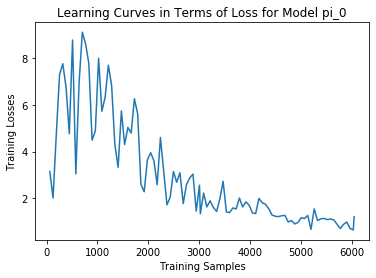

In [650]:
plt.plot(args.train_counter, args.train_losses)
plt.xlabel('Training Samples')
plt.ylabel('Training Losses')
plt.title('Learning Curves in Terms of Loss for Model ' + str(args.model_filename[0:4]))
plt.savefig('Learning Curves in Terms of Loss for Model ' + str(args.model_filename[0:4]))
plt.show()